**Student** : Samuel Guilluy \\
**Due Date** : 06/01/2020 \\
**Course** : Optimal Transport - Assignement 1

Optimal Transport with Linear Programming
=========================================


This numerical tours details how to solve the discrete optimal transport
problem (in the case of measures that are sums of Diracs) using linear
programming. \\
We will present the resolution of the discrete optimal transport problem using CVXPY and then present CVXPY in order to an Optimal Advertising problem.

## About CVXPY

 CVXPY allows to express the problem in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

After defining the Variable the Objectives and the Constraints,
CVXPY solved the Probelm in as a Python-embedded modeling language for convex optimization problems.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In discrete optimal transport, The Kantorovitch formulation of the optimal transport can be written as :
$$ P^\star \in \uargmin{P \in U(a,b)} \sum_{i,j} P_{i,j} C_{i,j}.  $$
where : $$ U(a,b) := \enscond{ P \in \RR_+^{n \times m} }{
     \forall i, \sum_j P_{i,j} = a_i, \:
     \forall j, \sum_i P_{i,j} = b_j }. $$

In the next part, we will solved this problem step by step using CVXPY.

Optimal Transport of Discrete Distributions
------------------------------------------

We consider two dicretes distributions
$$ \al = \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \be = \sum_{j=1}^m b_j \de_{y_j}. $$
   
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs in $\RR^d$. 

Dimensions $(n,m)$ of the coulds.

In [21]:
n = 60
m = 80

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$.

In [22]:
gauss = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))
#X = np.random.randn(2,n)*.3
theta = 2*np.pi*np.random.rand(1,n)
r = .4 + .2*np.random.rand(1,n)
X = np.vstack((np.cos(theta)*r,np.sin(theta)*r))



Y = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

Generate the weights $a,b$.

In [23]:
normalize = lambda a: a/np.sum(a)
a = normalize(np.random.rand(n, 1))
b = normalize(np.random.rand(m, 1))

Helper function for display of clouds.

In [24]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)

Display the point clouds.
The size of each dot is proportional to its probability density weight.

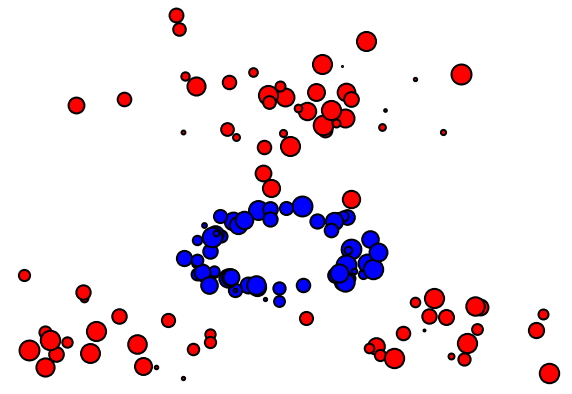

In [25]:
plt.figure(figsize = (10,7))
plt.axis("off")
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Compute the cost matrix $C_{i,j} := \norm{x_i-x_j}^2$.

In [26]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C = distmat(X,Y)

Define the optimiztion variable $P$.

In [27]:
P = cp.Variable((n,m))

Define the set of discrete couplings between $\al$ and $\be$
$$ U(a,b) := \enscond{ P \in \RR_+^{n \times m} }{
     \forall i, \sum_j P_{i,j} = a_i, \:
     \forall j, \sum_i P_{i,j} = b_j }. $$

In [28]:
u = np.ones((m,1))
v = np.ones((n,1))
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]

The Kantorovitch formulation of the optimal transport reads
$$ P^\star \in \uargmin{P \in U(a,b)} \sum_{i,j} P_{i,j} C_{i,j}.  $$
Solve it using CVXPY

In [29]:
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, U)
result = prob.solve()

An optimal coupling $P^\star$ can be shown to be a sparse matrix
with less than $n+m-1$ non zero entries. An entry $P_{i,j}^\star \neq 0$
should be understood as a link between $x_{i}$
and $y_{j}$ where an amount of mass equal to $P_{i,j}^\star$ is transfered.

Check that the number of non-zero entries in $P^\star$ is $n+m-1$. Beware that we are using an interior point method here, so that entries of $P^\star$ are nevery exactly 0.

In [30]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P.value[P.value>1e-5]), n + m-1))

Number of non-zero: 138 (n + m-1 = 139)


Display the solution coupling.

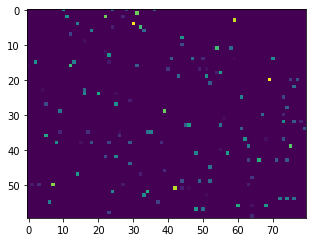

In [31]:
plt.figure(figsize = (5,5))
plt.imshow(P.value);

Display the connexion defined by the optimal coupling.

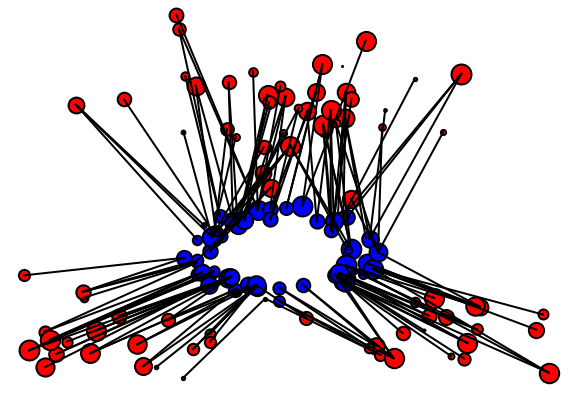

In [32]:
I,J = np.nonzero(P.value>1e-5)
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

# Optimal advertising

### Ad display

In this example we solve a simple optimal advertising problem in CVXPY.
We have $m$ advertisers/ads, $i=1, \ldots, m$, and $n$ time slots, $t=1, \ldots, n$.
$T_t$ is the total traffic in time slot $t$.
$D_{it} \geq 0$ is the number of ad $i$ displayed in period $t$.

Our constraints are that $\sum_i D_{it} \leq T_t$ and that we satisfy our contracts for minimum total displays: $\sum_t D_{it} \geq c_i$.
Our goal is to choose $D_{it}$.

### Clicks and revenue

$C_{it}$ is the number of clicks on ad $i$ in period $t$.
Our click model is $C_{it} = P_{it}D_{it}$, where $P_{it} \in [0,1]$ is the fraction of displays of ad $i$ in time $t$ that translate into clicks.

We are paid $R_i>0$ per click for ad $i$, up to a budget $B_i$.
Our total ad revenue is thus

$$
S_i = \min \left\{ R_i \sum_t C_{it}, B_i\right\},
$$

a concave function of $D$.

### Ad optimization
We choose the displays to maximize revenue, i.e., we solve the optimization problem

$$
\begin{array}{ll} \mbox{maximize} & \sum_i S_i \\
\mbox{subject to} & D \geq 0, \quad D^T{\bf 1} \leq T, \quad
D {\bf 1} \geq c
\end{array}
$$

where the optimization variable is $D\in {\bf R}^{m \times n}$ and $T \in {\bf R}^n$, $c \in {\bf R}^m$, $R \in {\bf R}^m$, $B \in {\bf R}^m$, and $P \in {\bf R}^{m \times n}$ are problem data.

This problem can be rewritten in a Kantorovich formulation :

$$ D^\star \in \uargmin{D \in U(T,c)} - \sum_{i,j} min(R_{i} \sum_{t}P_{it}D_{it},B_{i})  $$
where : $$ U(T,c) := \enscond{ D \in {\bf R}^{n \cdot m}, D \geq 0, \quad D^T{\bf 1} \leq T, \quad
D {\bf 1} \geq c }. $$

### Data example

In the following code we generate and solve an ad optimization problem with 24 hourly periods and 5 ads (A-E).

In [14]:
# Generate data for optimal advertising problem.
import numpy as np
np.random.seed(1)
m = 5
n = 24
SCALE = 10000
B = np.random.lognormal(mean=8, size=(m,1)) + 10000
B = 1000*np.round(B/1000)

P_ad = np.random.uniform(size=(m,1))
P_time = np.random.uniform(size=(1,n))
P = P_ad.dot(P_time)

T = np.sin(np.linspace(-2*np.pi/2,2*np.pi  -2*np.pi/2,n))*SCALE
T += -np.min(T) + SCALE
c = np.random.uniform(size=(m,))
c *= 0.6*T.sum()/c.sum()
c = 1000*np.round(c/1000)
R = np.array([np.random.lognormal(c.min()/c[i]) for i in range(m)])

In [15]:
# Form and solve the optimal advertising problem.
import cvxpy as cp

D = cp.Variable((m,n))
Si = [cp.minimum(R[i]*P[i,:]*D[i,:].T, B[i]) for i in range(m)]
prob = cp.Problem(cp.Maximize(cp.sum(Si)),
               [D >= 0,
                D.T @ np.ones(m) <= T,
                D @ np.ones(n) >= c])
print("The solution of the problem is : ",prob.solve())

The solution of the problem is :  42943.167385650355


We plot the total traffic $T$ below.

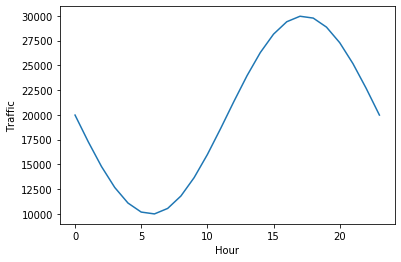

In [16]:
# Plot traffic.
import matplotlib.pyplot as plt

plt.plot(T)
plt.xlabel('Hour')
plt.ylabel("Traffic")
plt.show()

We plot the conversion fractions $P$ below.

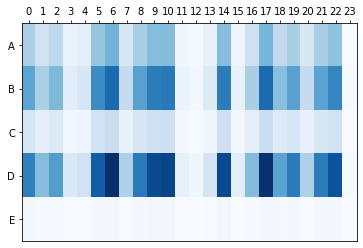

In [17]:
# Plot P.
column_labels = range(0,24)
row_labels = list('ABCDE')
fig, ax = plt.subplots()
data = D.value
heatmap = ax.pcolor(P, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(P.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(P.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

We plot the optimal displays $D$ below.

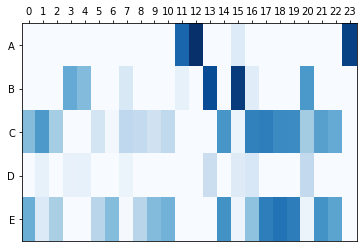

In [18]:
# Plot optimal D.
import matplotlib.pyplot as plt
%matplotlib inline
column_labels = range(0,24)
row_labels = list('ABCDE')
fig, ax = plt.subplots()
data = D.value
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

Displacement Interpolation
--------------------------
For any $t \in [0,1]$, one can define a distribution $\mu_t$ such
that $t \mapsto \mu_t$ defines a geodesic for the Wasserstein metric.


Since the $W_2$ distance is a geodesic distance, this geodesic path solves the
following variational problem

$$ \mu_t = \uargmin{\mu} (1-t)W_2(\al,\mu)^2 + t W_2(\be,\mu)^2. $$
This can be understood as a generalization of the usual Euclidean
barycenter to barycenter of distribution. Indeed, in the case that
$\al = \de_{x}$ and $\be=\de_y$, one has $\mu_t=\de_{x_t}$ where $ x_t =
(1-t)x+t y $.


Once the optimal coupling $P^\star$ has been computed, the
interpolated distribution is obtained as

$$ \mu_t = \sum_{i,j} P^\star_{i,j} \de_{(1-t)x_{i} + t y_{j}}. $$

Find the $i,j$ with non-zero $P_{i,j}^\star$.

In [33]:
I,J = np.nonzero(P.value>1e-5)
Pij = P.value[I,J]

Display the evolution of $\mu_t$ for a varying value of $t \in [0,1]$.

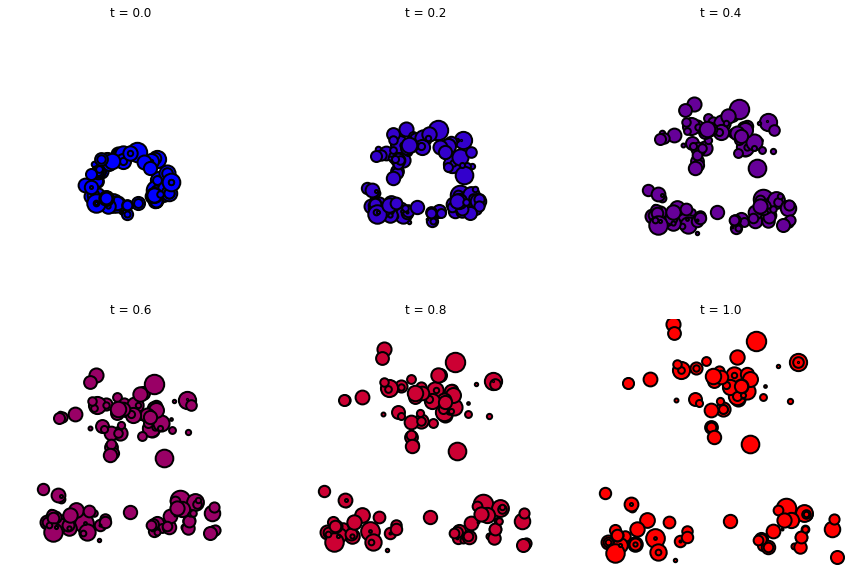

In [34]:
plt.figure(figsize =(15,10))
tlist = np.linspace(0, 1, 6)
for i in range(len(tlist)):
    t = tlist[i]
    Xt = (1-t)*X[:,I] + t*Y[:,J]
    plt.subplot(2,3,i+1)
    plt.axis("off")
    for j in range(len(Pij)):
        myplot(Xt[0,j],Xt[1,j],Pij[j]*len(Pij)*6,[[t,0,1-t]])
    plt.title("t = %.1f" %t) 
    plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
    plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Optimal Assignement
-------------------
In the case where $n=m$ and the weights are uniform $a_{i}=1/n, b_{j}=1/n$, one can show that there is at least one optimal transport coupling which is actually a
permutation matrix. This properties comes from the fact that
the extremal point of the polytope $U(1,1)$ are permutation matrices.


This means that there exists an optimal permutation $\si^\star \in \Sigma_n$ such
that
$$ P^\star_{i,j} = \choice{
      1 \qifq j=\si^\star(i), \\
      0 \quad\text{otherwise}.
  } $$
  
where $\Si_n$ is the set of permutation (bijections) of
$\{1,\ldots,n\}$.


This permutation thus solves the so-called optimal assignement problem
$$ \si^\star \in \uargmin{\si \in \Sigma_n}
      \sum_{i} C_{i,\si(j)}. $$

Use the same number of points.

In [35]:
n = 40
m = n

Compute points clouds.

In [36]:
#X = np.random.randn(2,n)*.3

theta = 2*np.pi*np.random.rand(1,n)
r = .4 + .2*np.random.rand(1,n)
X = np.vstack((np.cos(theta)*r,np.sin(theta)*r))


Y = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

Constant distributions.

In [37]:
a = np.ones([n,1])/n
b = a

Compute the weight matrix $ (C_{i,j})_{i,j}. $

In [38]:
C = distmat(X,Y)

Display the coulds.

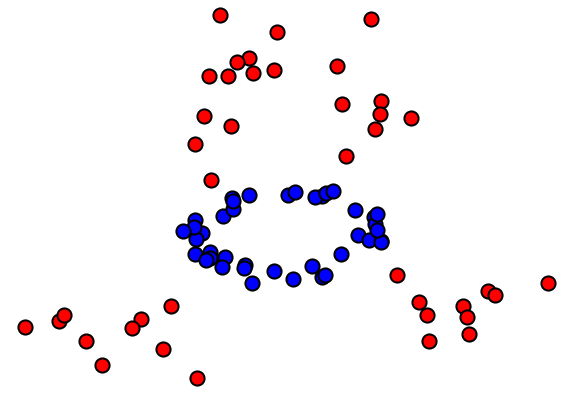

In [39]:
plt.figure(figsize = (10,7))
plt.axis('off')
myplot(X[0,:],X[1,:],10,'b')
myplot(Y[0,:],Y[1,:],10,'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Solve the optimal transport.

In [40]:
P = cp.Variable((n,m))
u = np.ones((m,1))
v = np.ones((n,1))
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, U)
result = prob.solve()

Show that $P$ is a binary permutation matrix.

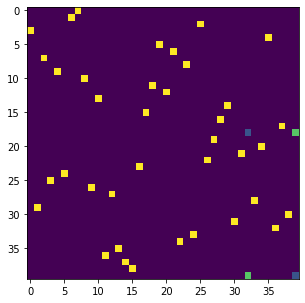

In [41]:
plt.figure(figsize = (5,5))
plt.imshow(P.value);

Display the optimal assignement.

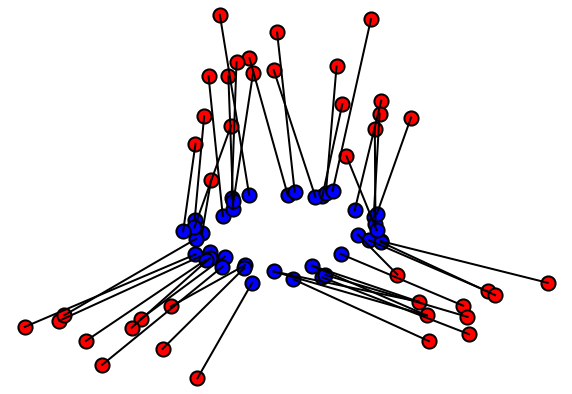

In [42]:
I,J = np.nonzero(P.value>1e-5)
plt.figure(figsize = (10,7))
plt.axis('off')
for k in range(len(I)):
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 2)
myplot(X[0,:], X[1,:], 10, 'b')
myplot(Y[0,:], Y[1,:], 10, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()